<a href="https://colab.research.google.com/github/Aakash-Gunda/Text-Translation-And-Summarization-Using-Deep-Neural-Networks/blob/main/hw3_ga2184.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3


# Question 1



### 1. Explain vanishing gradients phenomenon using standard normalization with different values of standard deviation, tanh and sigmoid activation functions. Then show how Xavier (aka Glorot normal) initialization of weights helps in dealing with this problem. Next use ReLU activation and show that instead of Xavier initialization, He initialization works better for ReLU activation. You can plot activations at each of the 5 layers to answer this question.

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import keras

from matplotlib import rcParamsDefault
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist

def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=categorical_crossentropy,
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.
    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x])
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

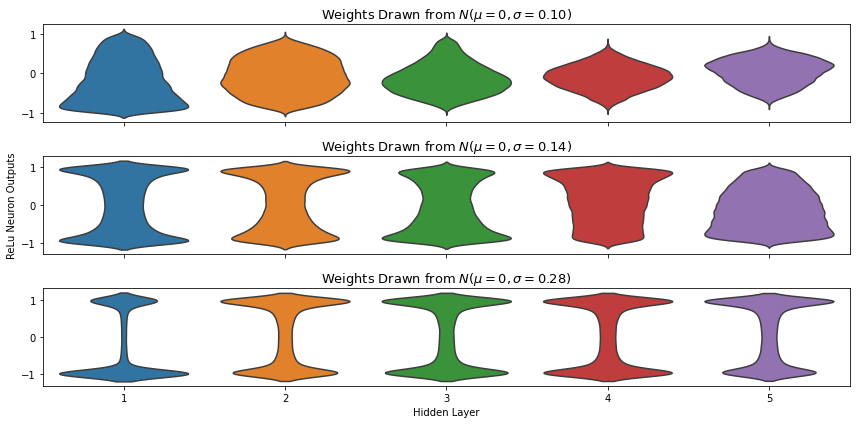

In [ ]:
seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0.10, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

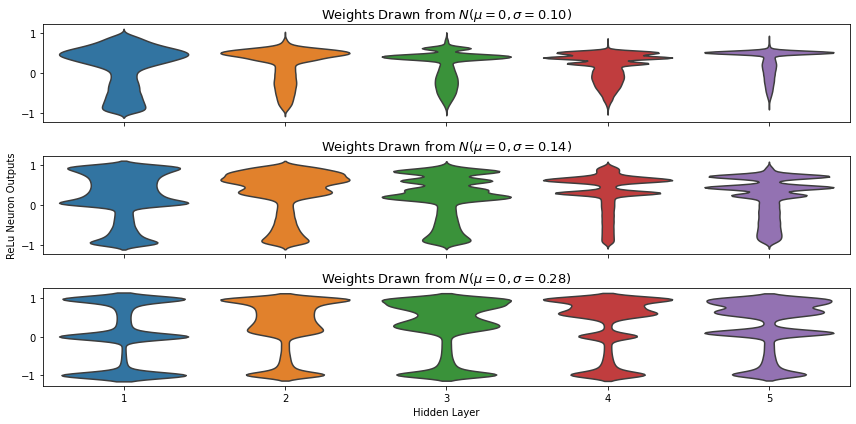

In [ ]:
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

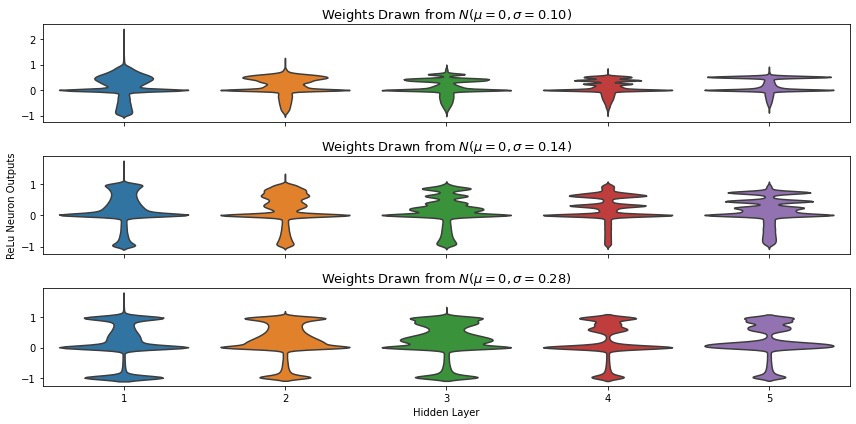

In [ ]:
for stddev in sigmas:
    init = initializers.GlorotNormal(seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

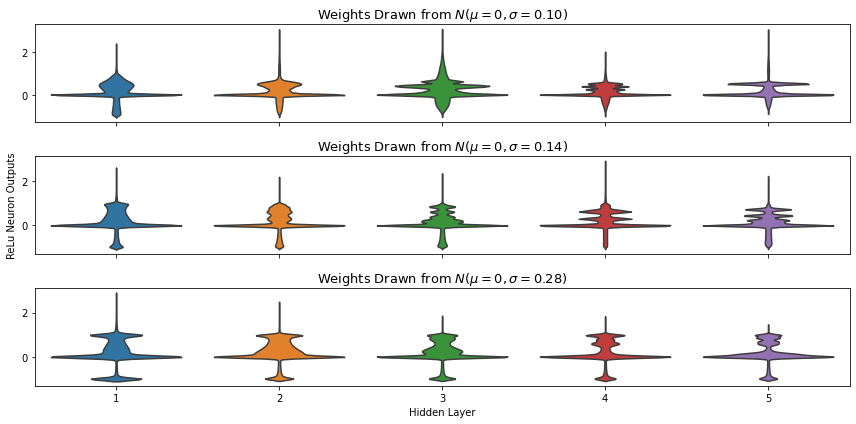

In [ ]:
for stddev in sigmas:
    init = initializers.HeNormal(seed=None)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

### 2. The dying ReLU is a kind of vanishing gradient, which refers to a problem when ReLU neurons become inactive and only output 0 for any input. In the worst case of dying ReLU, ReLU neurons at a certain layer are all dead, i.e., the entire network dies and is referred to as the dying ReLU neural networks in Lu et al (reference below). A dying ReLU neural network collapses to a constant function. Show this phenomenon using any one of the three 1-dimensional functions on page 13 of Lu et al. Use a 10-layer ReLU network with width 2 (hidden units per layer). Use minibatch of 64 and draw training data uniformly from [−√7,√7]. Perform 1000 independent training simulations each with 3,000 training points. Out of these 1000 simulations, what fraction resulted in neural network collapse. Is your answer close to over 90% as was reported in Lu et al. ?

In [ ]:
from keras import layers
from sklearn.model_selection import train_test_split

x = np.random.uniform(-np.sqrt(7),np.sqrt(7),3000)
y = x*np.sin(5*x)
x = x.reshape(-1,1)
y = y.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.20, random_state=1)

y_train = keras.utils.np_utils.to_categorical(y_train, 2)
y_test = keras.utils.np_utils.to_categorical(y_test, 2)

model = keras.Sequential()
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation="relu",kernel_initializer='HeNormal'))
model.add(layers.Dense(2, activation='relu',kernel_initializer='HeNormal'))
model.add(layers.Dense(2,activation = 'softmax'))

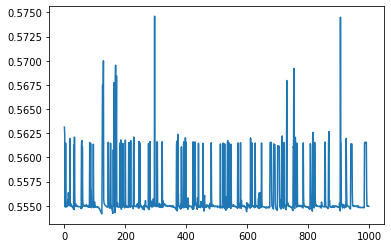

In [ ]:
loss_list = []
iter = range(1000)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

for i in range(1000):
  hist = model.fit(x=X_train,y=y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=0)
  loss_list.append(hist.history["loss"][0])

plt.plot(iter,loss_list)
plt.show()

In [ ]:
print('The fraction resulted in neural network collapse is:',loss_list[-1]*100/1000)

The fraction resulted in neural network collapse is: 0.055494844913482666


Yes, the answer is close to over 90% as was reported in Lu et al

### 3. Instead of ReLU consider Leaky ReLU activation as defined. Run the 1000 training simulations in part 2 with Leaky ReLU activation and keep everything else the same. Again calculate the fraction of simulations that resulted in neural network collapse. Did Leaky ReLU help in preventing dying neurons?

In [ ]:
model = keras.Sequential()

model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))
tf.keras.layers.LeakyReLU(alpha=0.3)
model.add(layers.Dense(2))

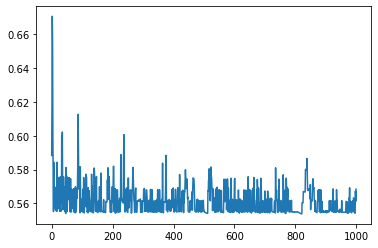

In [ ]:
loss_list_leaky = []
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

for i in range(1000):
  hist = model.fit(x=X_train,y=y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test), verbose=0)
  loss_list_leaky.append(hist.history["loss"][0])

plt.plot(iter,loss_list_leaky)
plt.show()

In [ ]:
print('The fraction resulted in neural network collapse is:',loss_list_leaky[-1]*100/1000)

The fraction resulted in neural network collapse is: 0.05684595108032227


Yes, Leaky ReLU is the most common and effective method to alleviate a dying neurons problem.

# Question 2

# Batch Normalization, Dropout, MNIST

1.1. **co-adaptation:-** In neural networks, co-adaptation refers is one of the main reasons which cause over-fitting. It happens when different hidden units in a neural networks have highly correlated behavior. If the independent neurons recieve bad inputs by any chance then it is highly likely that the dependent neurons will be affected as well and it ultimately affetcs the model performance causing overfitting.


1.2 **Internal covariance-shift:-** An internal covariate shift is the change in distribution of network parameters during training. It occurs when there is a change in the input distribution to our network. When the input distribution changes, hidden layers try to learn to adapt to the new distribution. This slows down the training process also deeper the network, the more tangled of a mess internal covariate shift can cause. 


https://medium.com/@lipeng2/dropout-is-so-important-e517bbe3ffcc
https://medium.com/analytics-vidhya/internal-covariate-shift-an-overview-of-how-to-speed-up-neural-network-training-3e2a3dcdd5cc

### 2. **Batch normalization**

The number of Batch Normalization parameters for the 3 hidden layers are 64, 480 and 336 respectively. The learned batch norm parameters are gamma weights, beta weights, moving mean and moving variance out of which moving mean and moving variance are non trainable.

In [ ]:
import keras
import tensorflow
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import BatchNormalization
from keras import models, layers
from keras.models import Sequential

# Load dataset as train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

from keras.models import Sequential
from keras import models, layers
import keras
#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
tf.keras.layers.LayerNormalization(trainable=True)

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))
model.add(BatchNormalization(trainable=True))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

# https://medium.com/analytics-vidhya/lenet-with-tensorflow-a35da0d503df

Epoch 1/10
469/469 [==============================] - 35s 73ms/step - loss: 0.3544 - accuracy: 0.8984 - val_loss: 0.2642 - val_accuracy: 0.9276
Epoch 2/10
469/469 [==============================] - 34s 73ms/step - loss: 0.2202 - accuracy: 0.9387 - val_loss: 0.2022 - val_accuracy: 0.9427
Epoch 3/10
469/469 [==============================] - 34s 73ms/step - loss: 0.1580 - accuracy: 0.9558 - val_loss: 0.1500 - val_accuracy: 0.9553
Epoch 4/10
469/469 [==============================] - 35s 74ms/step - loss: 0.1232 - accuracy: 0.9653 - val_loss: 0.1117 - val_accuracy: 0.9691
Epoch 5/10
469/469 [==============================] - 35s 74ms/step - loss: 0.1009 - accuracy: 0.9715 - val_loss: 0.0900 - val_accuracy: 0.9736
Epoch 6/10
469/469 [==============================] - 35s 75ms/step - loss: 0.0848 - accuracy: 0.9765 - val_loss: 0.0783 - val_accuracy: 0.9768
Epoch 7/10
469/469 [==============================] - 35s 75ms/step - loss: 0.0740 - accuracy: 0.9794 - val_loss: 0.0952 - val_accuracy:

### 3. Next instead of standard normalization use batch normalization for the input layer. 

**For the earlier case the train accuracy is 98.60%, train loss is 0.0497, the test accuracy is 98.25% and the test loss is 0.0564. For this case where we have used batchnorm instead of the standard normalization the train accuracy is 98.44%, train loss is 0.0540, the test accuracy is 98.55% and the test loss is 0.0488. So, in comparison the batchnorm model is slightly better but they give identical results.**


In [ ]:
import keras
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.layers import BatchNormalization
from keras import models, layers
from keras.models import Sequential

# Load dataset as train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Details about the dataset
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train[0].shape, 'image shape')

# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize value to [0, 1]
x_train /= 255
x_test /= 255

# Transform lables to one-hot encoding
num_classes = 10
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# Add a new axis
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
model.add(BatchNormalization(trainable=True))

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Activation('sigmoid'))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(layers.Activation('sigmoid'))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))
model.add(BatchNormalization(trainable=True))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

model.summary()

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
(28, 28) image shape
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 6)        24        
 hNormalization)                                                 
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 16)        2416      
                            

### 4. Train the network without batch normalization but this time use dropout. For hidden layers use a dropout probability of 0.5 and for input, layer take it to be 0.2 

**The test accuracy using dropout is 91.64% which is less when we compare it to the test accuracies in the previous two cases without the dropout.**

In [ ]:
from keras.layers import Dropout

#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
model.add(Dropout(0.2))

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Dropout(0.5))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(Dropout(0.5))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Dropout(0.5))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(Dropout(0.5))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))
model.add(Dropout(0.5))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
469/469 [==============================] - 64s 136ms/step - loss: 1.6836 - accuracy: 0.4362 - val_loss: 0.7208 - val_accuracy: 0.8227
Epoch 2/10
469/469 [==============================] - 46s 98ms/step - loss: 0.9574 - accuracy: 0.6887 - val_loss: 0.4740 - val_accuracy: 0.8724
Epoch 3/10
469/469 [==============================] - 40s 84ms/step - loss: 0.8077 - accuracy: 0.7376 - val_loss: 0.4021 - val_accuracy: 0.8874
Epoch 4/10
469/469 [==============================] - 40s 86ms/step - loss: 0.7418 - accuracy: 0.7593 - val_loss: 0.3646 - val_accuracy: 0.8980
Epoch 5/10
469/469 [==============================] - 39s 83ms/step - loss: 0.6976 - accuracy: 0.7759 - val_loss: 0.3421 - val_accuracy: 0.9035
Epoch 6/10
469/469 [==============================] - 39s 83ms/step - loss: 0.6656 - accuracy: 0.7867 - val_loss: 0.3254 - val_accuracy: 0.9074
Epoch 7/10
469/469 [==============================] - 40s 85ms/step - loss: 0.6423 - accuracy: 0.7965 - val_loss: 0.3115 - val_accuracy

### 5. Training the network using both batch normalization and dropout. 

**The test accuracy in this case is 94.58% which is better than the test accuracy of the model with dropout alone but it is still less when we look at the model with just batch normalization.**

In [ ]:
model = Sequential()

# C1 Convolutional Layer
model.add(layers.Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.2))

# S2 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Dropout(0.5))

# C3 Convolutional Layer
model.add(layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

# S4 Pooling Layer
model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Dropout(0.5))

# C5 Fully Connected Convolutional Layer
model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(layers.Flatten())

# FC6 Fully Connected Layer
model.add(layers.Dense(84, activation='tanh'))
model.add(BatchNormalization(trainable=True))
model.add(Dropout(0.5))

#Output Layer with softmax activation
model.add(layers.Dense(10, activation='softmax'))

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='SGD', metrics=['accuracy'])

hist = model.fit(x=x_train,y=y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test), verbose=1)

test_score = model.evaluate(x_test, y_test)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

Epoch 1/10
469/469 [==============================] - 53s 111ms/step - loss: 1.3388 - accuracy: 0.5723 - val_loss: 0.3968 - val_accuracy: 0.8792
Epoch 2/10
469/469 [==============================] - 53s 112ms/step - loss: 0.8234 - accuracy: 0.7325 - val_loss: 0.3364 - val_accuracy: 0.8989
Epoch 3/10
469/469 [==============================] - 52s 111ms/step - loss: 0.7229 - accuracy: 0.7684 - val_loss: 0.3060 - val_accuracy: 0.9076
Epoch 4/10
469/469 [==============================] - 52s 111ms/step - loss: 0.6566 - accuracy: 0.7925 - val_loss: 0.2811 - val_accuracy: 0.9178
Epoch 5/10
469/469 [==============================] - 52s 111ms/step - loss: 0.6218 - accuracy: 0.8021 - val_loss: 0.2633 - val_accuracy: 0.9226
Epoch 6/10
469/469 [==============================] - 52s 112ms/step - loss: 0.5751 - accuracy: 0.8178 - val_loss: 0.2455 - val_accuracy: 0.9274
Epoch 7/10
469/469 [==============================] - 52s 110ms/step - loss: 0.5493 - accuracy: 0.8279 - val_loss: 0.2273 - val_ac

# Problem 3 - Learning Rate, Batch Size, FashionMNIST



### Fix batch size to 64 and start with 10 candidate learning rates between 10−9 and 101 and train your model for 5 epochs. Plot the training loss as a function of the learning rate. You should see a curve like Figure 3 in the reference below. From that figure identify the values of lrmin and lrmax.

From the figure below lrmin is 1e-3 and lrmax is 10.

In [ ]:
!pip install tensorflow
import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']




Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


/home/ga2184/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ga2184/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ga2184/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ga2184/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [ ]:
import sys
sys.argv=['']
del sys

ap = argparse.ArgumentParser()
ap.add_argument("-f", "--lr-find", type=int, default=0,
	help="whether or not to find optimal learning rate")
args = vars(ap.parse_args())

In [ ]:
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")




[INFO] loading Fashion MNIST data...


In [ ]:
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras import backend as K

class MiniGoogLeNet:
    @staticmethod
    def conv_module(x, K, kX, kY, stride, chanDim, padding = "same"):
        # define a CONV => BN => RELU pattern
        x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
        x = tf.keras.layers.BatchNormalization(axis = chanDim)(x)
        x = Activation("relu")(x)

        # return the block
        return x

    @staticmethod
    def inception_module(x, numK1x1, numK3x3, chanDim):
        # define two CONV modules, then concatenate across the channel dimension
        conv_1x1 = MiniGoogLeNet.conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
        conv_3x3 = MiniGoogLeNet.conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
        x = concatenate([conv_1x1, conv_3x3], axis = chanDim)

        # return the block
        return x

    @staticmethod
    def downsample_module(x, K, chanDim):
        # define the CONV module and POOL, then concatenate across the channel dimensions
        conv_3x3 = MiniGoogLeNet.conv_module(x, K, 3, 3, (2, 2), chanDim, padding = "valid")
        pool = MaxPooling2D((3, 3), strides = (2, 2))(x)
        x = concatenate([conv_3x3, pool], axis = chanDim)

        # return the block
        return x

    @staticmethod
    def build(width, height, depth, classes):
        # initialize the input shape to be "channel last" and channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channel first", update the inpute shape and channel dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # define the model input and first CONV module
        inputs = Input(shape = inputShape)
        x = MiniGoogLeNet.conv_module(inputs, 96, 3, 3, (1, 1), chanDim)

        # two Inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 32, 32, chanDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 80, chanDim)

        # four Inception module followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 112, 48, chanDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, chanDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, chanDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 96, chanDim)

        # two Inception module followed by global POOL and dropout
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)

        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name = "googlenet")

        # return the constructed network architecture
        return model

In [ ]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
# !pip install google
# from pyimagesearch.minigooglenet import MiniGoogLeNet
import tensorflow as tf
MIN_LR = 1e-9
MAX_LR = 10
STEP_SIZE = 1
BATCH_SIZE = 64

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode='triangular',
	base_lr=1e-9,
	max_lr=10,
	step_size=10)
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=5,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=class_names))

[INFO] compiling model...
[INFO] training network...
Epoch 1/5
937/937 [==============================] - 375s 399ms/step - loss: 3.1184 - accuracy: 0.1005 - val_loss: 2.6897 - val_accuracy: 0.1000
Epoch 2/5
937/937 [==============================] - 371s 396ms/step - loss: 2.7241 - accuracy: 0.0993 - val_loss: 2.6557 - val_accuracy: 0.1000
Epoch 3/5
937/937 [==============================] - 371s 396ms/step - loss: 2.7441 - accuracy: 0.1010 - val_loss: 2.5779 - val_accuracy: 0.1000
Epoch 4/5
937/937 [==============================] - 369s 394ms/step - loss: 2.6866 - accuracy: 0.0984 - val_loss: 2.5430 - val_accuracy: 0.1000
Epoch 5/5
937/937 [==============================] - 369s 394ms/step - loss: 2.7836 - accuracy: 0.1000 - val_loss: 3.0060 - val_accuracy: 0.1000
[INFO] evaluating network...
              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.00      0

/home/ga2184/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ga2184/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ga2184/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		# store the model, stop factor, and beta value (for computing
		# a smoothed, average loss)
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta

		# initialize our list of learning rates and losses,
		# respectively
		self.lrs = []
		self.losses = []

		# initialize our learning rate multiplier, average loss, best
		# loss found thus far, current batch number, and weights file
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		# re-initialize all variables from our constructor
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def is_data_iter(self, data):
		# define the set of class types we will check for
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "Iterator", "Sequence"]

		# return whether our data is an iterator
		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		# grab the current learning rate and add log it to the list of
		# learning rates that we've tried
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)

		# grab the loss at the end of this batch, increment the total
		# number of batches processed, compute the average average
		# loss, smooth it, and update the losses list with the
		# smoothed value
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)

		# compute the maximum loss stopping factor value
		stopLoss = self.stopFactor * self.bestLoss

		# check to see whether the loss has grown too large
		if self.batchNum > 1 and smooth > stopLoss:
			# stop returning and return from the method
			self.model.stop_training = True
			return

		# check to see if the best loss should be updated
		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth

		# increase the learning rate
		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)

	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=32, sampleSize=2048,
		verbose=1):
		# reset our class-specific variables
		self.reset()

		# determine if we are using a data generator or not
		useGen = self.is_data_iter(trainData)

		# if we're using a generator and the steps per epoch is not
		# supplied, raise an error
		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)

		# if we're not using a generator then our entire dataset must
		# already be in memory
		elif not useGen:
			# grab the number of samples in the training data and
			# then derive the number of steps per epoch
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))

		# if no number of training epochs are supplied, compute the
		# training epochs based on a default sample size
		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

		# compute the total number of batch updates that will take
		# place while we are attempting to find a good starting
		# learning rate
		numBatchUpdates = epochs * stepsPerEpoch

		# derive the learning rate multiplier based on the ending
		# learning rate, starting learning rate, and total number of
		# batch updates
		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

		# create a temporary file path for the model weights and
		# then save the weights (so we can reset the weights when we
		# are done)
		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)

		# grab the *original* learning rate (so we can reset it
		# later), and then set the *starting* learning rate
		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)

		# construct a callback that will be called at the end of each
		# batch, enabling us to increase our learning rate as training
		# progresses
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))

		# check to see if we are using a data iterator
		if useGen:
			self.model.fit(
				x=trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				verbose=verbose,
				callbacks=[callback])

		# otherwise, our entire training data is already in memory
		else:
			# train our model using Keras' fit method
			self.model.fit(
				x=trainData[0], y=trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				callbacks=[callback],
				verbose=verbose)

		# restore the original model weights and learning rate
		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)

	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		# grab the learning rate and losses values to plot
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]

		# plot the learning rate vs. loss
		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")

		# if the title is not empty, add it to the plot
		if title != "":
			plt.title(title)

Epoch 1/3
938/938 [==============================] - 359s 382ms/step - loss: 7.0225 - accuracy: 0.1001
Epoch 2/3
938/938 [==============================] - 359s 383ms/step - loss: 6.9633 - accuracy: 0.1000
Epoch 3/3
938/938 [==============================] - 359s 382ms/step - loss: 3.2671 - accuracy: 0.0995


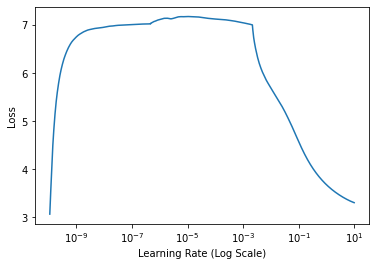

In [ ]:
lrf = LearningRateFinder(model)
lrf.find(
		aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
		1e-10, 1e+1,
		stepsPerEpoch=np.ceil((len(trainX) / float(BATCH_SIZE))),
		batchSize=BATCH_SIZE)

	# plot the loss for the various learning rates and save the
	# resulting plot to disk
lrf.plot_loss()

### 2. Use the cyclical learning rate policy (with exponential decay) and train your network using batch size 64 and lrmin and lrmax values obtained in part 1. Plot train/validation loss and accuracy curve (similar to Figure 4 in reference).

In [ ]:
MIN_LR = 1e-3
MAX_LR = 10

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode='triangular',
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=STEP_SIZE)
# train the network
print("[INFO] training network...")
H = model.fit(
	x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=5,
	callbacks=[clr],
	verbose=1)
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=class_names))

[INFO] compiling model...


/home/ga2184/.local/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


[INFO] training network...
Epoch 1/5
937/937 [==============================] - 371s 394ms/step - loss: 54116.1445 - accuracy: 0.1001 - val_loss: 10.9480 - val_accuracy: 0.1001
Epoch 2/5
937/937 [==============================] - 369s 394ms/step - loss: 19.0890 - accuracy: 0.1010 - val_loss: 20.1370 - val_accuracy: 0.1000
Epoch 3/5
937/937 [==============================] - 369s 394ms/step - loss: 15.3461 - accuracy: 0.1010 - val_loss: 12.3748 - val_accuracy: 0.1000
Epoch 4/5
937/937 [==============================] - 369s 393ms/step - loss: 15.7473 - accuracy: 0.0983 - val_loss: 19.6297 - val_accuracy: 0.1000
Epoch 5/5
937/937 [==============================] - 369s 393ms/step - loss: 15.2130 - accuracy: 0.0980 - val_loss: 19.7959 - val_accuracy: 0.1000
[INFO] evaluating network...
              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00      1000
     Trouser       0.00      0.00      0.00      1000
    Pullover       0.00      0.00      0.00

/home/ga2184/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ga2184/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ga2184/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


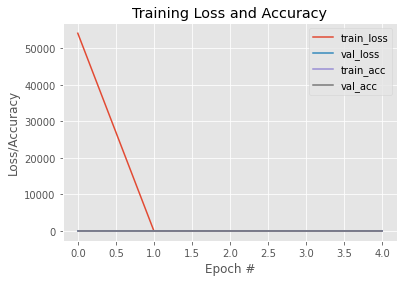

In [ ]:
# construct a plot that plots and saves the training history
N = np.arange(0, 5)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

### 3. We want to test if increasing batch size for a fixed learning rate has the same effect as decreasing learning rate for fixed batch size. Fix learning rate to lrmax and train your network starting with batch size 32 and incrementally going up to 16384 (in increments of a factor of 2; like 32, 64...). You can choose a step size (in terms of the number of iterations) to increment the batch size. If your GPU cannot handle large batch sizes, you need to employ an effective batch size approach as discussed in Lecture 3 to simulate large batches. Plot the training loss. Is the generalization of your final model similar or different from than cyclical learning rate policy?

In [ ]:
import warnings
warnings.filterwarnings("ignore")

MIN_LR = 10
MAX_LR = 10
STEP_SIZE = 1

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=MIN_LR, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

batch_size_list = [32,64,128,256,512,1024,2048,4096,8192,16384]
loss_list = []

for i in batch_size_list:

  stepSize = STEP_SIZE * (trainX.shape[0] // i)
  clr = CyclicLR(
    mode='triangular',
    base_lr=MIN_LR,
    max_lr=MAX_LR,
    step_size=STEP_SIZE)
  # train the network
  print("[INFO] training network...",'Batch Size:',i)
  H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=i),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // i,
    epochs=3,
    callbacks=  clr,
    verbose=1)
  # evaluate the network and show a classification report
  print("[INFO] evaluating network...")
  predictions = model.predict(x=testX, batch_size=i)
  print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=class_names))
  loss_list.append(H.history["loss"][-1])

[INFO] compiling model...
[INFO] training network... Batch Size: 32
Epoch 1/3
1875/1875 [==============================] - 390s 207ms/step - loss: 117892.5078 - accuracy: 0.0997 - val_loss: 5.3770 - val_accuracy: 0.1000
Epoch 2/3
1875/1875 [==============================] - 387s 207ms/step - loss: 6.2035 - accuracy: 0.0980 - val_loss: 4.9142 - val_accuracy: 0.1000
Epoch 3/3
1875/1875 [==============================] - 389s 207ms/step - loss: 6.2889 - accuracy: 0.0999 - val_loss: 8.0393 - val_accuracy: 0.1000
[INFO] evaluating network...
              precision    recall  f1-score   support

 T-shirt/top       0.00      0.00      0.00      1000
     Trouser       0.10      1.00      0.18      1000
    Pullover       0.00      0.00      0.00      1000
       Dress       0.00      0.00      0.00      1000
        Coat       0.00      0.00      0.00      1000
      Sandal       0.00      0.00      0.00      1000
       Shirt       0.00      0.00      0.00      1000
     Sneaker       0.00 

The generalization of your final model is similarto the cyclical learning rate policy and the test and train loss is better as compared to the model with cyclical learning rate.

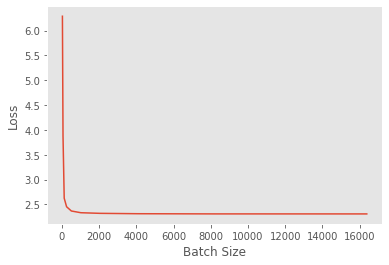

In [ ]:
loss_list = np.asarray(loss_list)
plt.plot(batch_size_list, loss_list)
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.grid()

# Problem 4

# Adaptive Learning Rate Methods, CIFAR-10

### 1. Write the weight update equations for the five adaptive learning rate methods.

**Adagrad**: Adagrad modifies the general learning rate η at each time step t for every parameter $\theta_{t}$ based on the past gradients that have been computed for $\theta_{t}$

$$\theta_{t+1,i} = \theta_{t,i} - \dfrac{\eta}{\sqrt{G_{t} + \epsilon}} \odot g_{t,i}$$

$\theta$ is the parameter, t is the current time, $\eta$ is the learning rate. $\epsilon$ is a smoothing term that prevents division by $0$. $\odot$ is the matrix-vector product. $g_t$ is the gradient at time step $t$. $G_{t}$ is a diagonal matrix where each diagonal element i,i  is the sum of the squares of the gradients w.r.t. $\theta_{i}$ up to time step t. $\epsilon$ is a smoothing term that avoids division by zero. In practice, AdaGrad tends to be substituted by using the Adam algorithm; since, for a given choice of hyperparameters, Adam is equivalent to AdaGrad and the hyperparameter for adam and adagrad are the sam.

**RMSProp**:  RMSprop as well divides the learning rate by an exponentially decaying average of squared gradients.

$$\begin{align} 
\begin{split} 
E[g^2]_t &= 0.9 E[g^2]_{t-1} + 0.1 g^2_t \\ 
\theta_{t+1} &= \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t} 
\end{split} 
\end{align}$$

The running average is given by $E[g^2]_t$ at time step t. The hyperparameters for RMSProp are the step size and rho(ρ). 

**RMSProp+Nesterov**: Adam can be viewed as a combination of RMSprop and momentum and then Nadam is equivalant to RMSProp+Nesterov. The final weight equation is given by

$$\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} (\beta_1 \hat{m}_t + \dfrac{(1 - \beta_1) g_t}{1 - \beta^t_1})$$

$\gamma$ is the momentum decay term. $\beta_1$ is the decay rate. $m_t$ is the momentum vector and it is given by $$m_t = β_1.m_{t−1}+(1−β_1).g_t$$. Nadam uses a decaying step size (alpha) and first moment (mu) hyperparameters.

**AdaDelta**: With Adadelta, we do not even need to set a default learning rate, as it has been eliminated from the update rule.


AdaDelta: $$\begin{align} 
\begin{split} 
\Delta \theta_t &= - \dfrac{RMS[\Delta \theta]_{t-1}}{RMS[g]_{t}} g_{t} \\ 
\theta_{t+1} &= \theta_t + \Delta \theta_t 
\end{split} 
\end{align}$$

RMS: Root Mean Squared error criterion. While AdaDelta is assumed to be parameter-free, there are some hyperparameters, they include ρ “rho” in running averages and the ε constant.

**Adam**: Adaptive Moment Estimation. The Adam weight update rule is given by

$$\theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

$m_t$ and $v_t$ are estimates of the first moment and the second moment of the gradients respectively. α, 𝛽1 (from Momentum), 𝛽2 (from RMSProp) are the hyperparameters for adam.

Adadelta uses the RMS of parameter updates in the numinator update rule. Adam, finally, adds bias-correction and momentum to RMSprop.

Reference: https://ruder.io/optimizing-gradient-descent/index.html#adam

### 2. Train the neural network using all the five methods with L2-regularization for 200 epochs each and plot the training loss vs the number of epochs. Which method performs best

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from tensorflow.keras import initializers
from keras.constraints import maxnorm
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
import time

In [ ]:
from keras.datasets import cifar10

#import dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#Preprocessing
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255.0
X_test /= 255.0

print(X_train.shape,
      y_train.shape,
      X_test.shape,
      y_test.shape)

170508288/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [ ]:
#Model

model = Sequential()
model.add(Flatten())
model.add(Dense(1000,activation='relu',kernel_regularizer='l2',kernel_initializer='HeNormal'))
model.add(Dense(1000,activation='relu',kernel_regularizer='l2',kernel_initializer='HeNormal'))
model.add(Dense(10, activation='softmax'))

#Adagrad
tf.keras.optimizers.Adagrad(
learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07,
name='Adagrad')

#RMSProp
tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop")

#RMSProp + Nesterov
tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

#AdaDelta
tf.keras.optimizers.Adadelta(
    learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta")

#Adam
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",)

In [ ]:
#Adagrad

model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])

# Fit model
tic = time.time()
history_adagrad = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 9s - loss: 41.0724 - accuracy: 0.2794 - val_loss: 40.0055 - val_accuracy: 0.3208 - 9s/epoch - 23ms/step
Epoch 2/200
391/391 - 4s - loss: 39.0470 - accuracy: 0.3511 - val_loss: 38.1227 - val_accuracy: 0.3468 - 4s/epoch - 10ms/step
Epoch 3/200
391/391 - 3s - loss: 37.2289 - accuracy: 0.3733 - val_loss: 36.3632 - val_accuracy: 0.3684 - 3s/epoch - 9ms/step
Epoch 4/200
391/391 - 3s - loss: 35.5266 - accuracy: 0.3876 - val_loss: 34.7057 - val_accuracy: 0.3908 - 3s/epoch - 7ms/step
Epoch 5/200
391/391 - 3s - loss: 33.9221 - accuracy: 0.3957 - val_loss: 33.1575 - val_accuracy: 0.3858 - 3s/epoch - 7ms/step
Epoch 6/200
391/391 - 3s - loss: 32.4062 - accuracy: 0.4019 - val_loss: 31.6750 - val_accuracy: 0.4034 - 3s/epoch - 7ms/step
Epoch 7/200
391/391 - 3s - loss: 30.9708 - accuracy: 0.4093 - val_loss: 30.2808 - val_accuracy: 0.4115 - 3s/epoch - 7ms/step
Epoch 8/200
391/391 - 3s - loss: 29.6119 - accuracy: 0.4156 - val_loss: 28.9601 - val_accuracy: 0.4127 - 3s/epoch - 7ms/ste

In [ ]:
#RMSProp

##Compiling
model.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])

# Fit model
tic = time.time()
history_RMS = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 5s - loss: 2.6412 - accuracy: 0.2113 - val_loss: 2.0925 - val_accuracy: 0.2821 - 5s/epoch - 12ms/step
Epoch 2/200
391/391 - 3s - loss: 2.1230 - accuracy: 0.2742 - val_loss: 2.1389 - val_accuracy: 0.2789 - 3s/epoch - 8ms/step
Epoch 3/200
391/391 - 3s - loss: 2.0646 - accuracy: 0.2987 - val_loss: 2.1291 - val_accuracy: 0.2848 - 3s/epoch - 8ms/step
Epoch 4/200
391/391 - 3s - loss: 2.0393 - accuracy: 0.3072 - val_loss: 2.1304 - val_accuracy: 0.2697 - 3s/epoch - 8ms/step
Epoch 5/200
391/391 - 3s - loss: 2.0096 - accuracy: 0.3198 - val_loss: 1.9615 - val_accuracy: 0.3273 - 3s/epoch - 8ms/step
Epoch 6/200
391/391 - 3s - loss: 1.9744 - accuracy: 0.3304 - val_loss: 1.9872 - val_accuracy: 0.3208 - 3s/epoch - 8ms/step
Epoch 7/200
391/391 - 3s - loss: 1.9496 - accuracy: 0.3380 - val_loss: 1.8898 - val_accuracy: 0.3643 - 3s/epoch - 8ms/step
Epoch 8/200
391/391 - 3s - loss: 1.9226 - accuracy: 0.3472 - val_loss: 1.9075 - val_accuracy: 0.3387 - 3s/epoch - 8ms/step
Epoch 9/200
391

In [ ]:
#Nadam
#Adam = RMSProp + Momentum
#Nadam = Adam + Nestrov Momentum
##Compiling
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

# Fit model
tic = time.time()
history_nadam = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 6s - loss: 1.7480 - accuracy: 0.4058 - val_loss: 1.7840 - val_accuracy: 0.3814 - 6s/epoch - 15ms/step
Epoch 2/200
391/391 - 4s - loss: 1.7424 - accuracy: 0.4041 - val_loss: 1.7953 - val_accuracy: 0.3844 - 4s/epoch - 11ms/step
Epoch 3/200
391/391 - 4s - loss: 1.7347 - accuracy: 0.4085 - val_loss: 1.7767 - val_accuracy: 0.4011 - 4s/epoch - 11ms/step
Epoch 4/200
391/391 - 4s - loss: 1.7298 - accuracy: 0.4093 - val_loss: 1.7023 - val_accuracy: 0.4307 - 4s/epoch - 11ms/step
Epoch 5/200
391/391 - 4s - loss: 1.7212 - accuracy: 0.4123 - val_loss: 1.6832 - val_accuracy: 0.4292 - 4s/epoch - 11ms/step
Epoch 6/200
391/391 - 4s - loss: 1.7211 - accuracy: 0.4127 - val_loss: 1.7468 - val_accuracy: 0.4081 - 4s/epoch - 11ms/step
Epoch 7/200
391/391 - 4s - loss: 1.7137 - accuracy: 0.4151 - val_loss: 1.7383 - val_accuracy: 0.4067 - 4s/epoch - 11ms/step
Epoch 8/200
391/391 - 4s - loss: 1.7062 - accuracy: 0.4183 - val_loss: 1.7815 - val_accuracy: 0.3913 - 4s/epoch - 11ms/step
Epoch 9/

In [ ]:
#Adadelta

##Compiling
model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

# Fit model
tic = time.time()
history_adadelta = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 4s - loss: 1.5704 - accuracy: 0.4642 - val_loss: 1.5910 - val_accuracy: 0.4611 - 4s/epoch - 9ms/step
Epoch 2/200
391/391 - 3s - loss: 1.5608 - accuracy: 0.4683 - val_loss: 1.5895 - val_accuracy: 0.4607 - 3s/epoch - 7ms/step
Epoch 3/200
391/391 - 3s - loss: 1.5590 - accuracy: 0.4685 - val_loss: 1.5880 - val_accuracy: 0.4620 - 3s/epoch - 7ms/step
Epoch 4/200
391/391 - 3s - loss: 1.5576 - accuracy: 0.4692 - val_loss: 1.5869 - val_accuracy: 0.4636 - 3s/epoch - 7ms/step
Epoch 5/200
391/391 - 3s - loss: 1.5565 - accuracy: 0.4691 - val_loss: 1.5861 - val_accuracy: 0.4653 - 3s/epoch - 7ms/step
Epoch 6/200
391/391 - 3s - loss: 1.5556 - accuracy: 0.4696 - val_loss: 1.5851 - val_accuracy: 0.4659 - 3s/epoch - 7ms/step
Epoch 7/200
391/391 - 3s - loss: 1.5548 - accuracy: 0.4693 - val_loss: 1.5844 - val_accuracy: 0.4659 - 3s/epoch - 7ms/step
Epoch 8/200
391/391 - 3s - loss: 1.5540 - accuracy: 0.4700 - val_loss: 1.5839 - val_accuracy: 0.4657 - 3s/epoch - 8ms/step
Epoch 9/200
391/

In [ ]:
#Adam

##Compiling
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Fit model
tic = time.time()
history_adam = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 4s - loss: 1.6543 - accuracy: 0.4335 - val_loss: 1.6372 - val_accuracy: 0.4409 - 4s/epoch - 9ms/step
Epoch 2/200
391/391 - 3s - loss: 1.6622 - accuracy: 0.4291 - val_loss: 1.6812 - val_accuracy: 0.4285 - 3s/epoch - 7ms/step
Epoch 3/200
391/391 - 3s - loss: 1.6546 - accuracy: 0.4307 - val_loss: 1.6182 - val_accuracy: 0.4528 - 3s/epoch - 7ms/step
Epoch 4/200
391/391 - 3s - loss: 1.6547 - accuracy: 0.4316 - val_loss: 1.6654 - val_accuracy: 0.4304 - 3s/epoch - 7ms/step
Epoch 5/200
391/391 - 3s - loss: 1.6569 - accuracy: 0.4302 - val_loss: 1.6463 - val_accuracy: 0.4423 - 3s/epoch - 7ms/step
Epoch 6/200
391/391 - 3s - loss: 1.6516 - accuracy: 0.4325 - val_loss: 1.6905 - val_accuracy: 0.4229 - 3s/epoch - 7ms/step
Epoch 7/200
391/391 - 3s - loss: 1.6575 - accuracy: 0.4323 - val_loss: 1.6872 - val_accuracy: 0.4229 - 3s/epoch - 7ms/step
Epoch 8/200
391/391 - 3s - loss: 1.6614 - accuracy: 0.4291 - val_loss: 1.6551 - val_accuracy: 0.4359 - 3s/epoch - 7ms/step
Epoch 9/200
391/

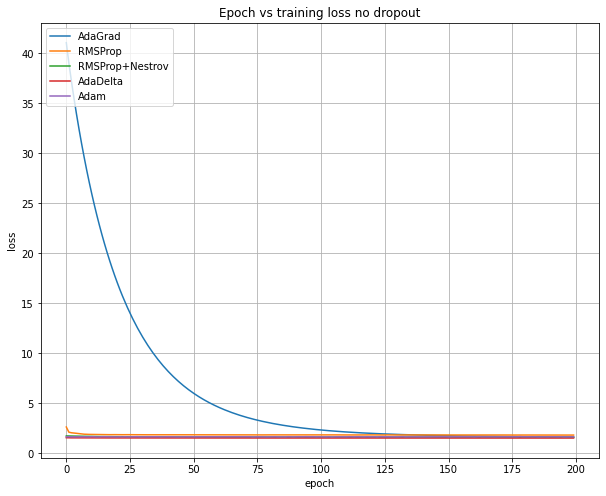

In [ ]:
#Plotting
fig = plt.figure(figsize=(10,8))
plt.plot(history_adagrad.history['loss'],label='AdaGrad')
plt.plot(history_RMS.history['loss'],label='RMSProp')
plt.plot(history_nadam.history['loss'],label='RMSProp+Nestrov')
plt.plot(history_adadelta.history['loss'],label='AdaDelta')
plt.plot(history_adam.history['loss'],label='Adam')
plt.title('Epoch vs training loss no dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.grid()
plt.show()

**From the above resuls by looking at all the training losses the model with Adadelta performs the best among them all.**

### 3. Add dropout and train the neural network again using all the five methods for 200 epochs. Compare the training loss with that in part 2. Which method performs the best? For the five methods, compare their training time to the training time in part 2

In [ ]:
#Model
model_dropout = Sequential()
model_dropout.add(Flatten())
model_dropout.add(Dropout(0.2))
model_dropout.add(Dense(1000,activation='relu',kernel_regularizer='l2',kernel_initializer='HeNormal'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(1000,activation='relu',kernel_regularizer='l2',kernel_initializer='HeNormal'))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(10, activation='softmax'))

In [ ]:
#Adagrad

model_dropout.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])

# Fit model
tic = time.time()
history_adagrad = model_dropout.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model_dropout.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 5s - loss: 41.4258 - accuracy: 0.1480 - val_loss: 40.1730 - val_accuracy: 0.2690 - 5s/epoch - 14ms/step
Epoch 2/200
391/391 - 3s - loss: 39.3398 - accuracy: 0.1944 - val_loss: 38.2998 - val_accuracy: 0.2876 - 3s/epoch - 7ms/step
Epoch 3/200
391/391 - 3s - loss: 37.5213 - accuracy: 0.2156 - val_loss: 36.5409 - val_accuracy: 0.2995 - 3s/epoch - 7ms/step
Epoch 4/200
391/391 - 3s - loss: 35.8107 - accuracy: 0.2325 - val_loss: 34.8849 - val_accuracy: 0.3174 - 3s/epoch - 7ms/step
Epoch 5/200
391/391 - 3s - loss: 34.1972 - accuracy: 0.2456 - val_loss: 33.3193 - val_accuracy: 0.3221 - 3s/epoch - 7ms/step
Epoch 6/200
391/391 - 3s - loss: 32.6743 - accuracy: 0.2538 - val_loss: 31.8455 - val_accuracy: 0.3197 - 3s/epoch - 7ms/step
Epoch 7/200
391/391 - 3s - loss: 31.2311 - accuracy: 0.2662 - val_loss: 30.4386 - val_accuracy: 0.3327 - 3s/epoch - 8ms/step
Epoch 8/200
391/391 - 3s - loss: 29.8665 - accuracy: 0.2725 - val_loss: 29.1101 - val_accuracy: 0.3349 - 3s/epoch - 7ms/step

In [ ]:
#RMSProp

##Compiling
model_dropout.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['accuracy'])

# Fit model
tic = time.time()
history_RMS = model_dropout.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model_dropout.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 5s - loss: 2.5398 - accuracy: 0.1825 - val_loss: 2.2548 - val_accuracy: 0.2228 - 5s/epoch - 12ms/step
Epoch 2/200
391/391 - 3s - loss: 2.2744 - accuracy: 0.2165 - val_loss: 2.1164 - val_accuracy: 0.2820 - 3s/epoch - 9ms/step
Epoch 3/200
391/391 - 3s - loss: 2.2476 - accuracy: 0.2240 - val_loss: 2.1252 - val_accuracy: 0.2795 - 3s/epoch - 9ms/step
Epoch 4/200
391/391 - 4s - loss: 2.2163 - accuracy: 0.2326 - val_loss: 2.2525 - val_accuracy: 0.2077 - 4s/epoch - 10ms/step
Epoch 5/200
391/391 - 3s - loss: 2.2037 - accuracy: 0.2383 - val_loss: 2.2809 - val_accuracy: 0.2103 - 3s/epoch - 9ms/step
Epoch 6/200
391/391 - 3s - loss: 2.1852 - accuracy: 0.2415 - val_loss: 2.1586 - val_accuracy: 0.2603 - 3s/epoch - 9ms/step
Epoch 7/200
391/391 - 4s - loss: 2.1600 - accuracy: 0.2459 - val_loss: 2.0527 - val_accuracy: 0.3253 - 4s/epoch - 10ms/step
Epoch 8/200
391/391 - 3s - loss: 2.1463 - accuracy: 0.2486 - val_loss: 2.0417 - val_accuracy: 0.2996 - 3s/epoch - 9ms/step
Epoch 9/200
3

In [ ]:
#Nadam
#Adam = RMSProp + Momentum
#Nadam = Adam + Nestrov Momentum
##Compiling
model_dropout.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

# Fit model
tic = time.time()
history_nadam = model_dropout.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model_dropout.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 6s - loss: 2.0880 - accuracy: 0.2423 - val_loss: 2.0904 - val_accuracy: 0.2408 - 6s/epoch - 15ms/step
Epoch 2/200
391/391 - 4s - loss: 2.1072 - accuracy: 0.2342 - val_loss: 2.0730 - val_accuracy: 0.2882 - 4s/epoch - 11ms/step
Epoch 3/200
391/391 - 4s - loss: 2.1042 - accuracy: 0.2324 - val_loss: 2.0648 - val_accuracy: 0.3003 - 4s/epoch - 11ms/step
Epoch 4/200
391/391 - 4s - loss: 2.0997 - accuracy: 0.2269 - val_loss: 2.0353 - val_accuracy: 0.3045 - 4s/epoch - 11ms/step
Epoch 5/200
391/391 - 4s - loss: 2.0992 - accuracy: 0.2253 - val_loss: 2.0958 - val_accuracy: 0.2505 - 4s/epoch - 11ms/step
Epoch 6/200
391/391 - 4s - loss: 2.0890 - accuracy: 0.2302 - val_loss: 2.0325 - val_accuracy: 0.2908 - 4s/epoch - 11ms/step
Epoch 7/200
391/391 - 4s - loss: 2.0914 - accuracy: 0.2321 - val_loss: 2.0263 - val_accuracy: 0.2936 - 4s/epoch - 11ms/step
Epoch 8/200
391/391 - 4s - loss: 2.0836 - accuracy: 0.2373 - val_loss: 2.0744 - val_accuracy: 0.2826 - 4s/epoch - 11ms/step
Epoch 9/

In [ ]:
#Adadelta

##Compiling
model_dropout.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

# Fit model
tic = time.time()
history_adadelta = model_dropout.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model_dropout.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 4s - loss: 2.0716 - accuracy: 0.2273 - val_loss: 2.0739 - val_accuracy: 0.2612 - 4s/epoch - 10ms/step
Epoch 2/200
391/391 - 3s - loss: 2.0594 - accuracy: 0.2311 - val_loss: 2.0657 - val_accuracy: 0.2645 - 3s/epoch - 8ms/step
Epoch 3/200
391/391 - 3s - loss: 2.0628 - accuracy: 0.2308 - val_loss: 2.0632 - val_accuracy: 0.2668 - 3s/epoch - 8ms/step
Epoch 4/200
391/391 - 3s - loss: 2.0598 - accuracy: 0.2334 - val_loss: 2.0614 - val_accuracy: 0.2660 - 3s/epoch - 8ms/step
Epoch 5/200
391/391 - 3s - loss: 2.0579 - accuracy: 0.2362 - val_loss: 2.0612 - val_accuracy: 0.2664 - 3s/epoch - 8ms/step
Epoch 6/200
391/391 - 3s - loss: 2.0575 - accuracy: 0.2362 - val_loss: 2.0604 - val_accuracy: 0.2665 - 3s/epoch - 8ms/step
Epoch 7/200
391/391 - 3s - loss: 2.0559 - accuracy: 0.2334 - val_loss: 2.0605 - val_accuracy: 0.2664 - 3s/epoch - 8ms/step
Epoch 8/200
391/391 - 3s - loss: 2.0583 - accuracy: 0.2325 - val_loss: 2.0601 - val_accuracy: 0.2672 - 3s/epoch - 8ms/step
Epoch 9/200
391

In [ ]:
#Adam

##Compiling
model_dropout.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Fit model
tic = time.time()
history_adam = model_dropout.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_test,y_test),shuffle=True,verbose=2)
toc = time.time()
print('Training Time:',toc-tic,'seconds')

_, acc = model_dropout.evaluate(X_test, y_test, verbose=0)
print('The test accuracy is:',acc)

Epoch 1/200
391/391 - 4s - loss: 2.1377 - accuracy: 0.2011 - val_loss: 2.0839 - val_accuracy: 0.2312 - 4s/epoch - 10ms/step
Epoch 2/200
391/391 - 3s - loss: 2.1348 - accuracy: 0.2047 - val_loss: 2.1260 - val_accuracy: 0.1916 - 3s/epoch - 8ms/step
Epoch 3/200
391/391 - 3s - loss: 2.1376 - accuracy: 0.1970 - val_loss: 2.1386 - val_accuracy: 0.2099 - 3s/epoch - 7ms/step
Epoch 4/200
391/391 - 3s - loss: 2.1202 - accuracy: 0.2043 - val_loss: 2.0991 - val_accuracy: 0.2282 - 3s/epoch - 7ms/step
Epoch 5/200
391/391 - 3s - loss: 2.1205 - accuracy: 0.2041 - val_loss: 2.0960 - val_accuracy: 0.2516 - 3s/epoch - 7ms/step
Epoch 6/200
391/391 - 3s - loss: 2.1373 - accuracy: 0.1936 - val_loss: 2.0759 - val_accuracy: 0.2167 - 3s/epoch - 7ms/step
Epoch 7/200
391/391 - 3s - loss: 2.1326 - accuracy: 0.1951 - val_loss: 2.1005 - val_accuracy: 0.2215 - 3s/epoch - 8ms/step
Epoch 8/200
391/391 - 3s - loss: 2.1289 - accuracy: 0.1992 - val_loss: 2.0955 - val_accuracy: 0.2385 - 3s/epoch - 7ms/step
Epoch 9/200
391

#### Solution

If we compare the training loss with the above section Adadelta performs the best in both the cases. If we look at the training time almost all the times are similar to that of the above section with minute differences.

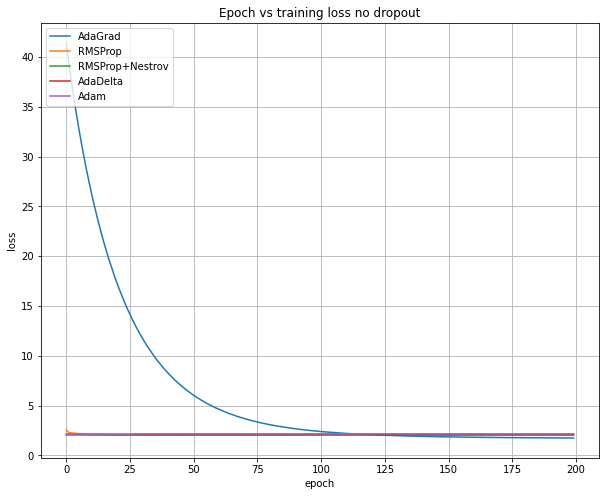

In [ ]:
#Plotting
fig = plt.figure(figsize=(10,8))
plt.plot(history_adagrad.history['loss'],label='AdaGrad')
plt.plot(history_RMS.history['loss'],label='RMSProp')
plt.plot(history_nadam.history['loss'],label='RMSProp+Nestrov')
plt.plot(history_adadelta.history['loss'],label='AdaDelta')
plt.plot(history_adam.history['loss'],label='Adam')
plt.title('Epoch vs training loss no dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.grid()
plt.show()

### 4. Compare test accuracy of the trained model for all the five methods from part 2 and part 3.

Test accuracy for model without dropout:
Adagrad: 0.5034 <br>
RMSProp: 0.3763 <br>
RMSProp+N: 0.4410 <br>
AdaDelta: 0.4693 <br>
Adam: 0.4449 <br>

Test accuracy for dropout: <br>
Adagrad: 0.4788 <br>
RMSProp: 0.2300 <br>
RMSProp+N: 0.2495 <br>
AdaDelta: 0.2754 <br>
Adam: 0.1862

The test accuracy for the model without dropout is better.

# Problem 5

# Convolutional Neural Networks Architectures

#### 1. Calculate the number of parameters in Alexnet.


Parameters = (size of kernels^2 * # of channels in input image * number of kernels) + number of kernels <br>

Output of ConvLayer = (input - size of kernels + 2*padding)/stride + 1
Output of MaxPool = (input - pool size)/stride + 1

**C1: First Convolution Layer**The first layer of AlexNet was a convolutional layer that accepted a (224×224×3) image tensor as its input. It performed a convolution operation using 96 (11×11) kernels with a stride of four and a padding of two. This produced a (55×55×96) output tensor that was then passed through a ReLu activation function then on to the next layer. <br>

$(11)^2(3)(96)+96 = 34944$ parameters; size: 55 x 55 x 96 <br>

**C3: Second Convolution Layer**:The third layer of AlexNet was another convolutional layer that accepted output from the layer S2, a (27×27×96) tensor, as its input. It performed a convolution operation using 256 (5×5) kernels with a stride of one, and a padding of two. This operation produced a (27×27×256) output tensor that was then passed through a ReLu activation function, and then on to the next layer.<br>
 $(5)^2(96)(256)+256=614656$ parameters; size: 27 x 27 x 256 <br>

**C5: Third Convolution Layer:** The fifth layer of AlexNet was another convolutional layer that accepted output from the layer C5, a (13×13×256) tensor, as its input. It performed a convolution operation using 384 (3×3) kernels with a stride and padding of one. This produced a (13×13×384) output tensor that was then passed through a ReLu activation function, and then on to the next layer.<br>

$(3)^2(256)(384)+384=885120$ parameters; size: 13 x 13 x 384 <br>

**C6: Fourth Convolution Layer:** The sixth layer of AlexNet was another convolutional layer that accepted output from the layer C5, a (13×13×384) tensor, as its input. It performed the same convolution operation as layer C5, which lead to the same output size. The output was also passed through a ReLu activation function.<br>
(3)^2(384)(384)+384=1327488$ parameters; size: 13 x 13 x 384 <br>

**C7: Fifth Convolution Layer:** The seventh layer of AlexNet was another convolutional layer that accepted a (13×13×384) tensor from the layer C6 as its input. It performed a convolution operation using 256 (3×3) kernels with a stride and padding of 1. This produced a (13×13×256) output tensor.
$(3)^2(384)(256)+256=884992$ parameters; size: 13 x 13 x 256 <br>

**F9: First Fully Connected Layer:** The ninth layer of AlexNet was a fully connected layer that accepted a flattened (6×6×256) tensor from the layer S8 as its input. It performed a weighted sum operation with an added bias term. This produced a (4096×1) output tensor that was then passed through a ReLu activation function, and on to the next layer. <br>
$(1)^2(9216)(4096)+4096=37752832$ parameters; size = 4096 x 1 <br>

**F10: Second Fully Connected Layer:** The tenth layer of AlexNet was another fully connected layer that accepted a (4096×1) tensor from the layer F9 as its input. It performed the same operation as layer F9 and produced the same (4096×1) output tensor that was then passed through a ReLu activation function, and then on to the next layer.<br>
$(1)^2(4096)(4096)+4096=16781312$ parameters; size = 4096 x 1 <br>

**F11: Third Fully Connected Layer:** The eleventh and final layer of the network was also a fully connected layer that accepted a (4096×1) tensor from the layer F10 as its input. It performed the same operation as layer F9 and F10 and produced a (1000×1) output tensor that was then passed through a softmax activation function.<br>
$(1)^2(4096)(1000)+1000=4097000$ parameters; size = 4096 x 1 <br>

Total: $62,378,344$ parameters

###2. VGG (Simonyan et al.)

CONV3-128: Number of Activations: $(112)(112)(128)=1605632$; Parameters: $3(3)(64)(128)=73728$<br>

CONV3-128: Number of Activations: $(112)(112)(128)=1605632$; Parameters: $3(3)(128)(128)=147456$<br>

CONV3-256: Number of Activations: $(56)(56)(256)=802816$; Parameters: $3(3)(128)(256)=294912$<br>

CONV3-256: Number of Activations: $(56)(56)(256)=802816$; Parameters: $3(3)(256)(256)=589824$<br>

CONV3-256: Number of Activations: $(56)(56)(256)=802816$; Parameters: $3(3)(256)(256)=589824$<br>

POOL2: Number of Activations: $28(28)(256)=200704$ <br>

CONV3-512: Number of Activations: $(28)(28)(512)=401408$; Parameters: $3(3)(256)(512)=1179648$<br>

CONV3-512: Number of Activations: $(28)(28)(512)=401408$; Parameters: $3(3)(512)(512)=2359296$<br>

CONV3-512: Number of Activations: $(28)(28)(512)=401408$; Parameters: $3(3)(512)(512)=2359296$<br>

POOL2: Memory: $14(14)(512)=100353$ <br>

CONV3-512: Memory: $(14)(14)(512)=100352$; Parameters: $3(3)(512)(512)=2359296$<br>

CONV3-512: Memory: $(14)(14)(512)=100352$; Parameters: $3(3)(512)(512)=2359296$<br>

CONV3-512: Memory: $(14)(14)(512)=100352$; Parameters: $3(3)(512)(512)=2359296$<br>

CONV3-512: Memory: $(14)(14)(512)=100352$; Parameters: $3(3)(512)(512)=2359296$<br>

POOL2: Memory: $7(7)(512)=25088$ <br>

FC: Parameters: $4096(25088)=102760488$ <br>

FC: Parameters: $4096(1000)=4096000$ <br>

Total: Memory: ~$16.5M$, Parameters ~$140M$:

### 3. VGG architectures have smaller filters but deeper networks compared to Alexnet


Stack of N convolution layer of filter size FxF: <br>
$S_1^K=S-F+1$, where $S$ is the shape and $K$ is the kernel <br>
Doing it $n$ times: $S_n^K=S-N(F+1)$ <br>

For one convolution layer with filter of size (NF-N+1)x(NF-N+1), the size is: <br>
$S-(NF-N+1)+1 = S-N(F+1)$ 

Hence, a stack of N convolution layers each of filter size F × F has the same
receptive field as one convolution layer with filter of size (NF − N + 1) × (NF − N + 1).

the receptive field of 3 filters of size 5x5 is 75 weights (and +1 bias parameter).

### 4. The original Googlenet paper (Szegedy et al.) proposes two architectures for Inception module, shown in Figure 2 on page 5 of the paper, referred to as naive and dimensionality reduction respectively.

a) An Inception Module is aims to approximate an optimal local sparse structure by allowing us to use multiple types of filter size, instead of being restricted to a single filter size, in a single image block, which we then concatenate and pass onto the next layer.

b) Assuming the input to inception module output size after filter concatenation for the naive architecture is 672 and dimensionality reduction inception architectures is 480

c) Number of convolutional operations: <br>

Naive version: <br>
CONV1 = 32 x 32 x 1 x 256 x 128 = 33554432 <br>
CONV3 = 32 x 32 x 9 x 256 x 192 = 452984832 <br>
CONV5 = 32 x 32 x 25 x 256 x 96 = 629145600 <br>
Total = 1115684864 <br>

Dimensionality Reduction: <br>
CONV1 = (32 x 32 x 256 x 128) + (32 x 32 x 256 x 128) + (32 x 32 x 256 x 64) + (32 x 32 x 256 x 32) = 92274688 <br>
CONV3 = 32 x 32 x 9 x 128 x 192 = 226492416 <br>
CONV5 = 32 x 32 x 25 x 32 x 96 = 78643200 <br>
Total = 397410304 <br>


d) The computational saving for the naive architecture is 2.80 times more expensive than Dimensionality Reduction. Dimensionality Reduction helps by having smaller outputs for every inception module. It removes the computational bottlenecks, that would otherwise limit the size of our networks. This allows for not just increasing the depth, but also the width of our networks without significant performance penalty. The dimensionality reduction architecture allows for increasing the number of units at each stage significantly without an uncontrolled blow-up in the computational complexity of the overall model.